In [305]:
import time, collections, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.io.image import read_image

# !pip install grad-cam
from pytorch_grad_cam import GradCAM, EigenGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.metrics.road import ROADCombined, ROADMostRelevantFirst

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla P100-PCIE-16GB


In [277]:
EPOCHS = 5
BATCH_SIZE = 32
NUM_CLASSES = 196

model = models.resnet18(pretrained=True)
nb_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(nb_ftrs, NUM_CLASSES)
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [278]:
dataset_dir = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/"

# Apply some data_augmentation
train_tfms = transforms.Compose([transforms.Resize((256, 256)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

test_tfms = transforms.Compose([transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset = torchvision.datasets.ImageFolder(root=dataset_dir+"train", transform = train_tfms)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = BATCH_SIZE, shuffle=False)

In [279]:
def train_model(model, criterion, optimizer, scheduler):
    losses = []
    accuracies = []
    test_accuracies = []
    
    model.train()
    model=model.to('cuda')
    for epoch in range(EPOCHS):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
            inputs, labels = data
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
                
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()

        epoch_duration = time.time() - since
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100 / BATCH_SIZE * running_correct / len(trainloader)
        print("duration: %d s, epoch %s, loss: %.4f, accuracy: %.4f" % (epoch_duration, epoch+1, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        model.eval()
        test_acc = eval_mode(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    return model

In [280]:
def eval_mode(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_acc = 100.0 * correct / total
    return test_acc

In [281]:
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
trained_model = train_model(model, criterion, optimizer, lrscheduler)

100%|██████████| 255/255 [02:24<00:00,  1.76it/s]


duration: 144 s, epoch 1, loss: 4.0558, accuracy: 13.9951


100%|██████████| 255/255 [02:12<00:00,  1.92it/s]


duration: 132 s, epoch 2, loss: 1.8413, accuracy: 52.7451


100%|██████████| 255/255 [02:22<00:00,  1.79it/s]


duration: 142 s, epoch 3, loss: 1.0721, accuracy: 71.3235


100%|██████████| 255/255 [02:23<00:00,  1.77it/s]


duration: 143 s, epoch 4, loss: 0.6887, accuracy: 80.1961


100%|██████████| 255/255 [02:12<00:00,  1.92it/s]


duration: 132 s, epoch 5, loss: 0.4621, accuracy: 87.1446


In [282]:
# Get misclassified examples

# Assume model, test_loader and device are already defined
model.eval()  # Set the model to evaluation mode
to_pil = ToPILImage()

misclassified_examples = []

with torch.no_grad():  # No need to track gradients
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        
        # Check for misclassifications
        misclassifications = predictions != labels
        for image, label, prediction in zip(images[misclassifications], labels[misclassifications], predictions[misclassifications]):
            misclassified_examples.append((image.cpu(), label.cpu(), prediction.cpu()))
            

# Assuming misclassified_examples is a list of tuples (image, true_label, predicted_label)
error_counts = collections.Counter()
for _, true_label, _ in misclassified_examples:
    error_counts[true_label.item()] += 1
    
# Convert the counter to a DataFrame
error_df = pd.DataFrame(list(error_counts.items()), columns=['Class', 'Error Count'])
error_df = error_df.sort_values(by="Error Count", ascending=False)
error_df['Class_name'] = error_df['Class'].apply(lambda x : dataset2.classes[x])

error_df

Class  Error Count                       Class_name
23      23           36              Audi TTS Coupe 2012
11      11           35              Audi 100 Sedan 1994
17      17           33               Audi S4 Sedan 2012
60      60           31       Chevrolet Express Van 2007
88      89           30       Dodge Dakota Crew Cab 2010
..     ...          ...                              ...
157    159            2       McLaren MP4-12C Coupe 2012
84      85            2       Dodge Challenger SRT8 2011
152    154            1  Land Rover Range Rover SUV 2012
38      38            1        Bentley Arnage Sedan 2009
61      61            1            Chevrolet HHR SS 2010

[194 rows x 3 columns]

In [283]:
def get_all_files_from_class(class_name):
    folder_path = os.path.join("/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/", class_name + "/")
    file_names = os.listdir(folder_path)
    return file_names

In [334]:
def visualize_score(visualization, score):
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 20), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 40), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA) 
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 60), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    return visualization


def get_gradiant_cam_of_model(class_name):
    cam_images = []

    target_layers = [trained_model.layer4]
    targets = [ClassifierOutputTarget(195)]
    metric_targets = [ClassifierOutputSoftmaxTarget(195)]
    
    cam = EigenGradCAM(model=model, target_layers=target_layers)
    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    
    file_names = get_all_files_from_class(class_name)
    
    for file in file_names:
        image_path = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/" + class_name + "/" + file 

        img = np.array(Image.open(image_path))
        img = cv2.resize(img, (224, 224))
        img = np.float32(img) / 255

        input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)
        
        attributions = cam(input_tensor=input_tensor, targets=targets)
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        
        cam_image = show_cam_on_image(img, attributions[0, :], use_rgb=True)
        cam_image = visualize_score(cam_image, scores[0])
        
        cam_images.append(cam_image)

    max_images_per_row = 6
    for i in range(0, len(cam_images), max_images_per_row):
        images_row = cam_images[i:i+max_images_per_row]
        row_image = np.hstack(images_row)
        display(Image.fromarray(row_image))

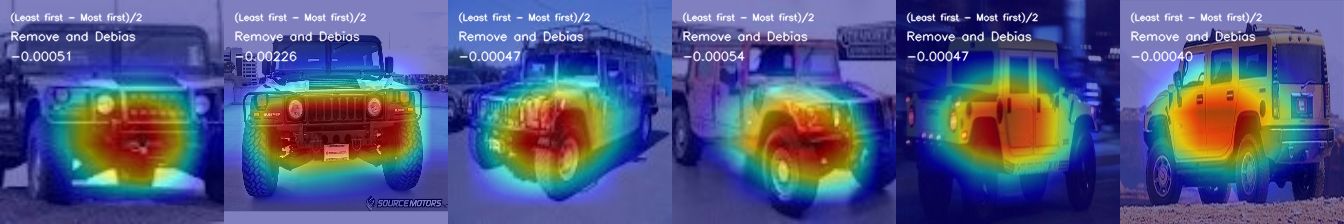

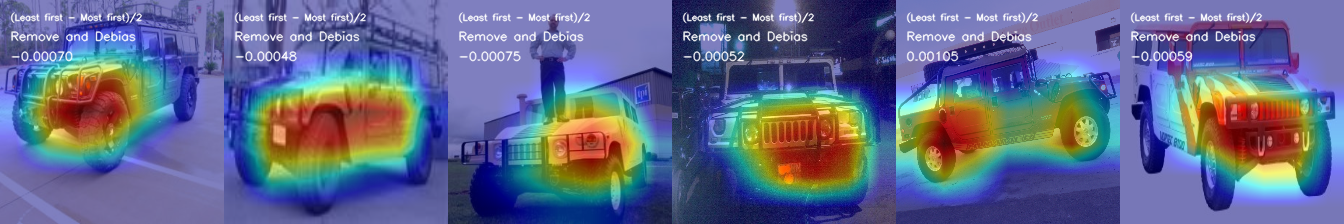

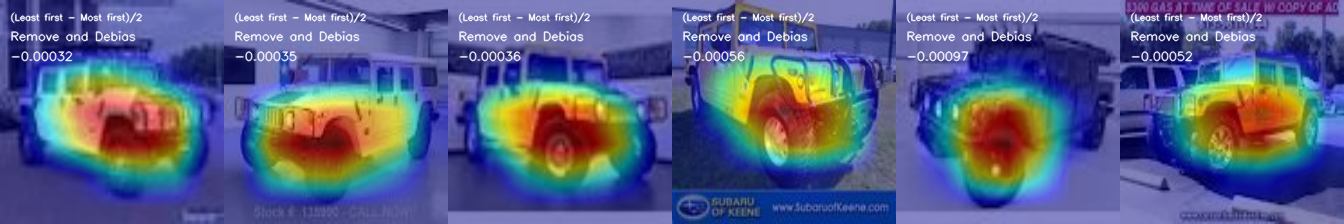

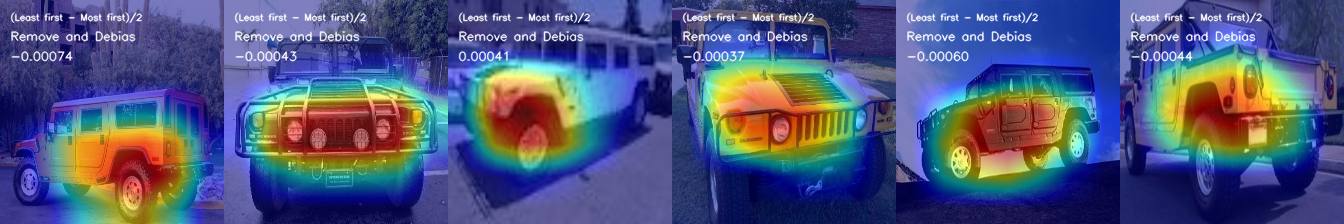

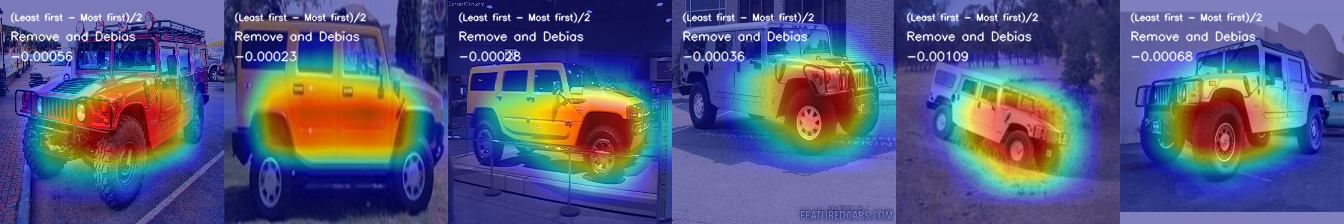

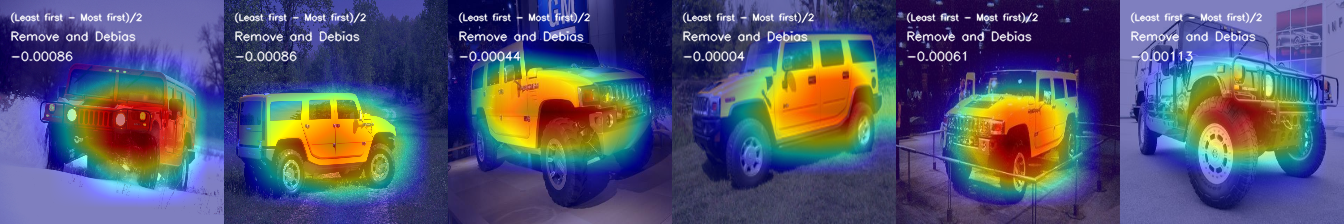

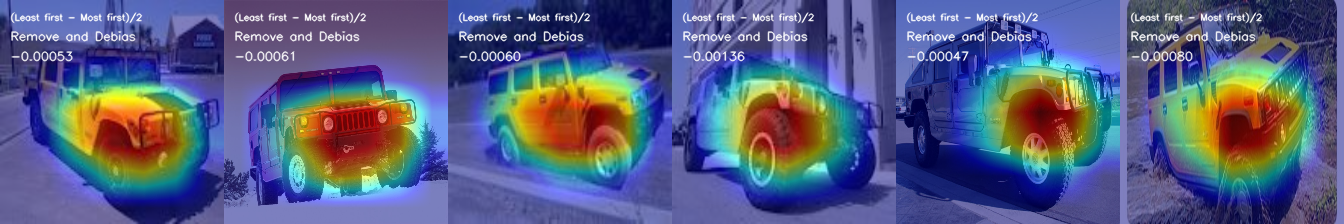

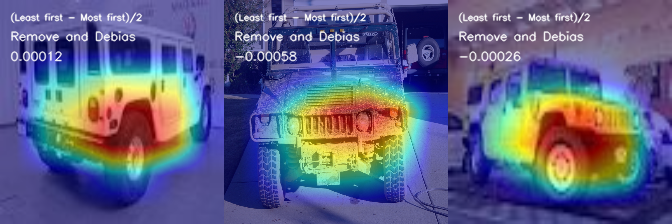

In [335]:
get_gradiant_cam_of_model("AM General Hummer SUV 2000")
#get_gradiant_cam_of_model("Bentley Continental GT Coupe 2007")

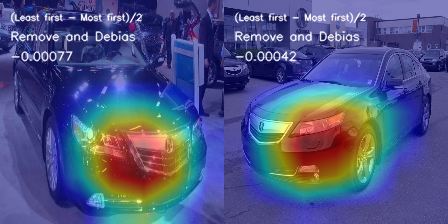

In [340]:
# code de 2 modèles qui se ressemblent avec grad
rl = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Acura RL Sedan 2012/03875.jpg"
tl = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Acura TL Sedan 2012/00002.jpg"

def grad_on_similar_images():
    cam_images = []

    target_layers = [trained_model.layer4]
    targets = [ClassifierOutputTarget(195)]
    metric_targets = [ClassifierOutputSoftmaxTarget(195)]
    
    cam = EigenGradCAM(model=model, target_layers=target_layers)
    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    
    file_names = [rl, tl]
    
    for image_path in file_names:
        img = np.array(Image.open(image_path))
        img = cv2.resize(img, (224, 224))
        img = np.float32(img) / 255

        input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)
        
        attributions = cam(input_tensor=input_tensor, targets=targets)
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        
        cam_image = show_cam_on_image(img, attributions[0, :], use_rgb=True)
        cam_image = visualize_score(cam_image, scores[0])
        
        cam_images.append(cam_image)

    res = np.hstack(cam_images)
    display(Image.fromarray(res))
    
grad_on_similar_images()

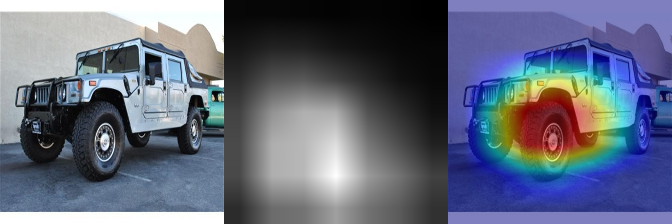

In [345]:
# Black pixel
file = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/AM General Hummer SUV 2000/00163.jpg"

target_layers = [trained_model.layer4]
targets = [ClassifierOutputTarget(195)]
metric_targets = [ClassifierOutputSoftmaxTarget(195)]
    
cam = EigenGradCAM(model=model, target_layers=target_layers)
cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    
img = np.array(Image.open(file))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255

input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)
        
attributions = cam(input_tensor=input_tensor, targets=targets)
        
cam_image = show_cam_on_image(img, attributions[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)